In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px 
RESCALE_SIZE = 224
#MODELS = ['resnet34', 'densenet']
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [3]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [4]:
class GoodsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
            
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
 #Проверить какие преобразования на самом деле нужны!!! 
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(RESCALE_SIZE),
            transforms.CenterCrop(RESCALE_SIZE),
            #transforms.RandomResizedCrop(RESCALE_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(RESCALE_SIZE),
            transforms.CenterCrop(RESCALE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(RESCALE_SIZE),
            transforms.CenterCrop(RESCALE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        }
        x = self.load_sample(self.files[index])
        if (len(x.mode) < 2):
            x = transforms.Grayscale(3)(x)
        transforms.functional.adjust_saturation(img=x,saturation_factor=1.25)
        transforms.functional.adjust_gamma(img=x, gamma=0.25)
        x = data_transforms[self.mode](x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [5]:
TRAIN_DIR=Path('/kaggle/input/digix-ai-train/train_data/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

In [6]:
labels_file = open('/kaggle/input/digix-ai-train/train_data/label.txt','r')
train_val_labels = sorted([line.strip() for line in labels_file])
for i in range(len(train_val_labels)):
    train_val_labels[i-1] = 'thingummy #' + train_val_labels[i-1].split(',')[-1]

In [7]:
# Возвращает массив в формате ((именена классов), (индекс первой картинки такого класса),(сколько всего таких картинок))
#unique_img_info = np.unique(np.array(train_val_labels),return_counts=True, return_index=True)

#print(unique_img_info)
#Берем индексы картинок , которые встречаются только один раз, индексы в массиве который создала строка выше
#unique_img_idx_indicies = np.array(np.where(unique_img_info[2] == 1))
#print(unique_img_idx_indicies)

#unique_img_idx_indicies = unique_img_idx_indicies[0,:] # Убираем лишнее измерение [[]] -> []
 
#unique_img_indicies = list()
#unique_img_dir_indicies = list()
#for idx in unique_img_idx_indicies:
#    unique_img_dir_indicies.append(np.int64(unique_img_info[0][idx].split('#')[-1]))
#    unique_img_indicies.append(unique_img_info[1][idx])

In [8]:

#data = []
#for i in range(len(data_prev[0])):
#    data.append((i,data_prev[2][i]))
#    
#max_num_in_data = data_prev[2].max()
#data

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#data = pd.DataFrame(data)
#data = data.rename(columns={0: "idx",1:"Num of img"})

In [10]:
data_prev = np.unique(np.array(train_val_labels),return_index=True,return_counts=True)
weights_for_classes = torch.FloatTensor(data_prev[2].max()/np.array(data_prev[2]))
weights_for_classes = (weights_for_classes/weights_for_classes.mean()).cuda()
weights_for_classes

tensor([0.6167, 0.6727, 0.7400,  ..., 0.9867, 1.4800, 0.9250], device='cuda:0')

In [11]:
#Сортируем их, чтобы добавлять по порядку и учитывать новые элементы в списке не ломая голову с преобразованием индексов
#unique_img_indicies = np.sort(unique_img_indicies)[::-1]

#Сортируем по отдельности, но чем больше номер папки тем больше номер картинки и все норм
#unique_img_dir_indicies = np.sort(unique_img_dir_indicies)[::-1]

In [12]:
#unique_img_dir_indicies

In [13]:
#list(Path('/kaggle/input/digix-ai-train/train_data/DIGIX_' + '{:06}'.format(608) +'/').rglob('*.jpg'))

In [14]:
#for i in range(len(unique_img_dir_indicies)):
#    str_idx = '{:06}'.format(unique_img_dir_indicies[i])
#    img_path = list(Path('/kaggle/input/digix-ai-train/train_data/DIGIX_' + str_idx +'/').rglob('*.jpg'))[0]
#    img = Image.open(img_path)
#    img_name, ext = os.path.splitext(img_path)
#    img.transpose(Image.FLIP_LEFT_RIGHT).save(img_name + '_1','JPEG')
#    train_val_labels.insert(unique_img_indicies[i], train_val_labels[unique_img_indicies[i]])

In [15]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_val_files, test_size=0.3, 
                                          stratify=train_val_labels)

In [16]:
val_dataset = GoodsDataset(val_files, mode='val')

In [17]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

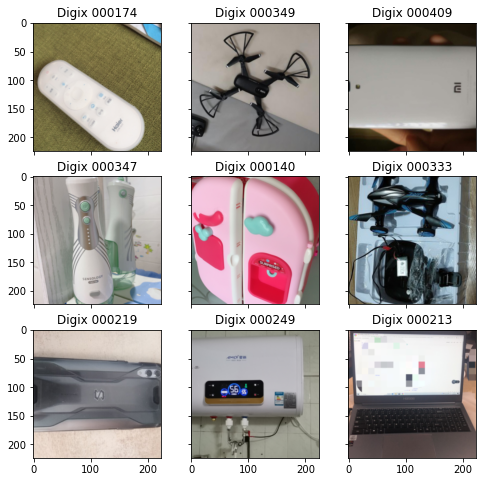

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,3000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [19]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16035 sha256=240e8b25177e9c234260d66efe42059aa923d213a0c67f15f06906bf2c32b876
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
Successfully built efficientnet-pytorch
Note: you may need to restart the kernel to use updated packages.


In [20]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b1')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth



Loaded pretrained weights for efficientnet-b1


In [21]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [22]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [23]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [24]:
parameters_list = []
for name, param in model.named_parameters():
        parameters_list.append(name)
        
parameters_list

['_conv_stem.weight',
 '_bn0.weight',
 '_bn0.bias',
 '_blocks.0._depthwise_conv.weight',
 '_blocks.0._bn1.weight',
 '_blocks.0._bn1.bias',
 '_blocks.0._se_reduce.weight',
 '_blocks.0._se_reduce.bias',
 '_blocks.0._se_expand.weight',
 '_blocks.0._se_expand.bias',
 '_blocks.0._project_conv.weight',
 '_blocks.0._bn2.weight',
 '_blocks.0._bn2.bias',
 '_blocks.1._depthwise_conv.weight',
 '_blocks.1._bn1.weight',
 '_blocks.1._bn1.bias',
 '_blocks.1._se_reduce.weight',
 '_blocks.1._se_reduce.bias',
 '_blocks.1._se_expand.weight',
 '_blocks.1._se_expand.bias',
 '_blocks.1._project_conv.weight',
 '_blocks.1._bn2.weight',
 '_blocks.1._bn2.bias',
 '_blocks.2._expand_conv.weight',
 '_blocks.2._bn0.weight',
 '_blocks.2._bn0.bias',
 '_blocks.2._depthwise_conv.weight',
 '_blocks.2._bn1.weight',
 '_blocks.2._bn1.bias',
 '_blocks.2._se_reduce.weight',
 '_blocks.2._se_reduce.bias',
 '_blocks.2._se_expand.weight',
 '_blocks.2._se_expand.bias',
 '_blocks.2._project_conv.weight',
 '_blocks.2._bn2.weight',


In [25]:
def set_parameter_requires_grad(model):
    for name, param in model.named_parameters():
        param.requires_grad = False

In [26]:
model._fc.in_features

1280

In [27]:
n_classes = len(np.unique(train_val_labels))
set_parameter_requires_grad(model)

additional_ftrs = 4096

#Изменяем выходные слои моделей
num_ftrs_resnext = model._fc.in_features
new_fc_seq = nn.Sequential(
    nn.Linear(num_ftrs_resnext,additional_ftrs),
    nn.LeakyReLU(),
    nn.Linear(additional_ftrs, n_classes)
)
model._fc = new_fc_seq

In [28]:
params_to_update = []
for name,p in model.named_parameters():
    if p.requires_grad:
        print(name)
        params_to_update.append(p)

_fc.0.weight
_fc.0.bias
_fc.2.weight
_fc.2.bias


In [29]:
def train(train_files, val_files, model, epochs, batch_size, params_to_update, weights, lr = 0.001):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(params_to_update, lr)
        criterion = nn.CrossEntropyLoss(weight=weights)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [30]:
model = model.to(DEVICE)

In [31]:
if val_dataset is None:
    val_dataset = GoodsDataset(val_files, mode='val')
    
train_dataset = GoodsDataset(train_files, mode='train')

In [32]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [33]:
for name,p in model.named_parameters():
    if name.split('.')[0] == '_bn0':
        num = 0
    elif name.split('.')[1] == 'weight' :
        num = 4
    elif name.split('.')[1] == 'bias' :
        num = 4
    else :
        num = int(name.split('.')[1])
    if num > 2:
        p.requires_grad = True
        print(name)
        params_to_update.append(p)

_conv_stem.weight
_blocks.3._expand_conv.weight
_blocks.3._bn0.weight
_blocks.3._bn0.bias
_blocks.3._depthwise_conv.weight
_blocks.3._bn1.weight
_blocks.3._bn1.bias
_blocks.3._se_reduce.weight
_blocks.3._se_reduce.bias
_blocks.3._se_expand.weight
_blocks.3._se_expand.bias
_blocks.3._project_conv.weight
_blocks.3._bn2.weight
_blocks.3._bn2.bias
_blocks.4._expand_conv.weight
_blocks.4._bn0.weight
_blocks.4._bn0.bias
_blocks.4._depthwise_conv.weight
_blocks.4._bn1.weight
_blocks.4._bn1.bias
_blocks.4._se_reduce.weight
_blocks.4._se_reduce.bias
_blocks.4._se_expand.weight
_blocks.4._se_expand.bias
_blocks.4._project_conv.weight
_blocks.4._bn2.weight
_blocks.4._bn2.bias
_blocks.5._expand_conv.weight
_blocks.5._bn0.weight
_blocks.5._bn0.bias
_blocks.5._depthwise_conv.weight
_blocks.5._bn1.weight
_blocks.5._bn1.bias
_blocks.5._se_reduce.weight
_blocks.5._se_reduce.bias
_blocks.5._se_expand.weight
_blocks.5._se_expand.bias
_blocks.5._project_conv.weight
_blocks.5._bn2.weight
_blocks.5._bn2.bia

In [34]:
history = train(train_dataset, val_dataset, model=model, epochs=2, batch_size=64, lr=3e-4, params_to_update=params_to_update, weights=weights_for_classes)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 4.008334397319365


epoch:  50%|█████     | 1/2 [48:37<48:37, 2917.92s/it]


Epoch 001 train_loss: 4.0083     val_loss 1.3915 train_acc 0.2964 val_acc 0.6045
loss 0.9124351742964437


epoch: 100%|██████████| 2/2 [1:37:25<00:00, 2922.64s/it]


Epoch 002 train_loss: 0.9124     val_loss 1.0180 train_acc 0.7024 val_acc 0.6998


In [35]:
loss, acc, val_loss, val_acc = zip(*history)

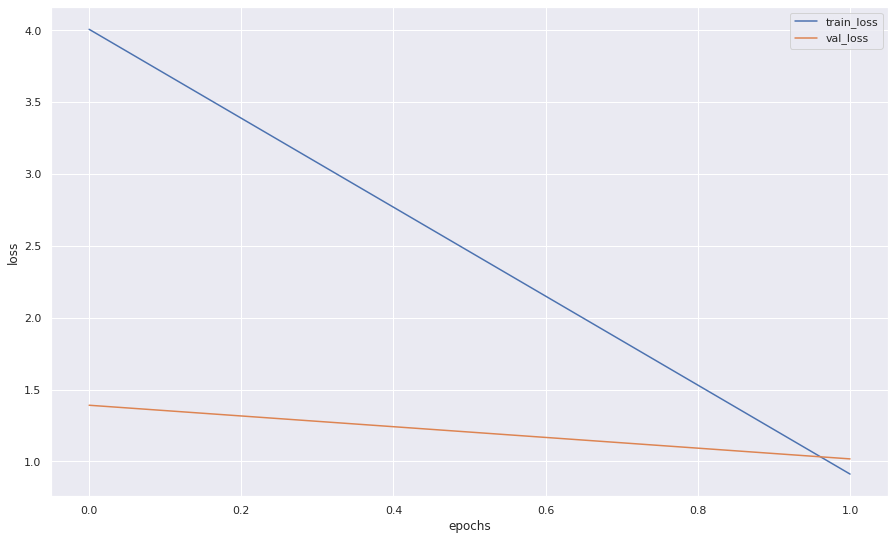

In [36]:
sns.set()
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [37]:
path_model = "eff_net_w.pt"
torch.save(model.state_dict(), path_model)

In [38]:
history_2 = train(train_dataset, val_dataset, model=model, epochs=3, batch_size=64, lr=3e-4, params_to_update=params_to_update, weights=weights_for_classes)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 0.5274751363869475


epoch:  33%|███▎      | 1/3 [48:53<1:37:46, 2933.14s/it]


Epoch 001 train_loss: 0.5275     val_loss 0.9523 train_acc 0.8093 val_acc 0.7393
loss 0.2993268104194815


epoch:  67%|██████▋   | 2/3 [1:36:35<48:31, 2911.99s/it]


Epoch 002 train_loss: 0.2993     val_loss 0.9179 train_acc 0.8774 val_acc 0.7547
loss 0.22068168017162942


epoch: 100%|██████████| 3/3 [2:24:38<00:00, 2892.78s/it]


Epoch 003 train_loss: 0.2207     val_loss 0.9629 train_acc 0.9078 val_acc 0.7559


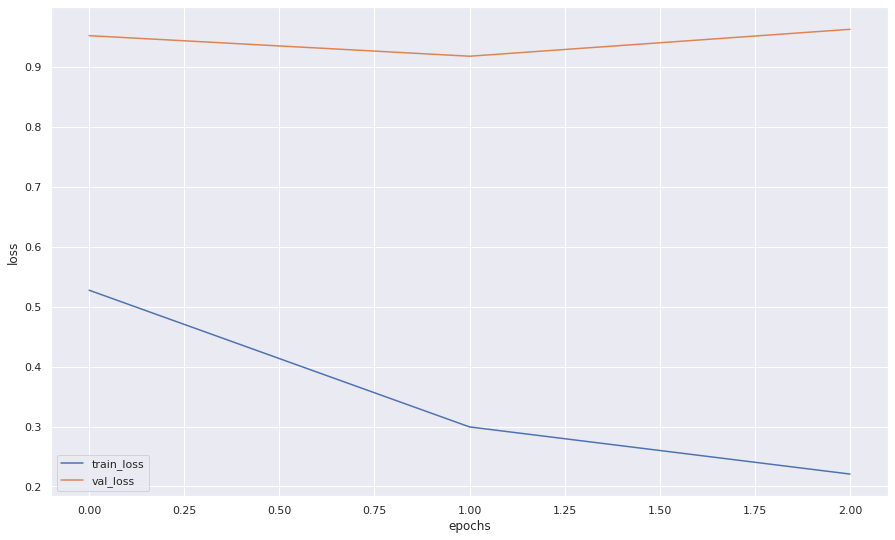

In [39]:
loss, acc, val_loss, val_acc = zip(*history_2)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [40]:
path_model = "eff_net_w_2.pt"
torch.save(model.state_dict(), path_model)

In [41]:
history_3 = train(train_dataset, val_dataset, model=model, epochs=6, batch_size=64, lr=3e-6, params_to_update=params_to_update, weights=weights_for_classes)

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

loss 0.11320451673306095


epoch:  17%|█▋        | 1/6 [49:11<4:05:55, 2951.01s/it]


Epoch 001 train_loss: 0.1132     val_loss 0.8094 train_acc 0.9462 val_acc 0.7906
loss 0.07654902205285383


epoch:  33%|███▎      | 2/6 [1:39:03<3:17:34, 2963.54s/it]


Epoch 002 train_loss: 0.0765     val_loss 0.7870 train_acc 0.9595 val_acc 0.8006
loss 0.059197587429680905


epoch:  50%|█████     | 3/6 [2:29:25<2:29:03, 2981.12s/it]


Epoch 003 train_loss: 0.0592     val_loss 0.7830 train_acc 0.9666 val_acc 0.8054
loss 0.048433865589863984


epoch:  67%|██████▋   | 4/6 [3:17:51<1:38:37, 2958.53s/it]


Epoch 004 train_loss: 0.0484     val_loss 0.7912 train_acc 0.9721 val_acc 0.8071
loss 0.0410506767625739


epoch:  83%|████████▎ | 5/6 [4:06:25<49:05, 2945.20s/it]


Epoch 005 train_loss: 0.0411     val_loss 0.8038 train_acc 0.9751 val_acc 0.8094
loss 0.036165816248445684


epoch: 100%|██████████| 6/6 [4:55:05<00:00, 2951.00s/it]


Epoch 006 train_loss: 0.0362     val_loss 0.8186 train_acc 0.9773 val_acc 0.8107


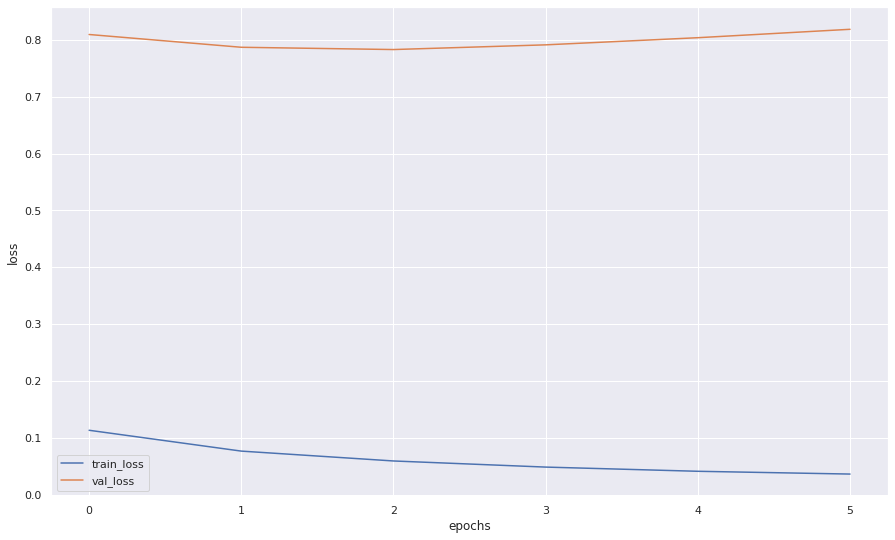

In [42]:

loss, acc, val_loss, val_acc = zip(*history_3)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()